In [2]:
import requests
import os
import glob
import pandas as pd
import wget
from tqdm import tqdm_notebook as tqdm
import zipfile
import util
import swifter

# CSVs

In [2]:
csv_path = '../bills/bulk-bill-data/csvs/'
states = pd.Series([
    "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
    "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
    "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
    "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
    "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"
])

to_get = states.str.lower().loc[lambda s: ~s.isin(os.listdir(csv_path))]
generic_csv_url = "https://data.openstates.org/legacy/csv/%s.zip"

for state in tqdm(to_get, total=len(to_get)):
    state_folder = os.path.join(csv_path, state) 
    os.mkdir(state_folder)
    state_csv_url = generic_csv_url % state
    wget.download(state_csv_url, out=state_folder)

In [53]:
zip_files = glob.glob("../bills/bulk-bill-data/csvs/*/*.zip")

In [57]:
for zip_file in tqdm(zip_files):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        par_dir = os.path.dirname(zip_file)
        zip_ref.extractall(par_dir)

In [69]:
bills_csvs = glob.glob("../bills/bulk-bill-data/csvs/*/*_bills.csv")

In [89]:
bills = pd.concat([
    pd.read_csv(bills_csv)
    for bills_csv in bills_csvs
]).reset_index(drop=True)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3248: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [91]:
bills['created_at'] = pd.to_datetime(bills['created_at'])

In [122]:
ls ..\\bills

 Volume in drive C is Local Disk
 Volume Serial Number is 3422-B048

 Directory of C:\Users\alexa\Projects\usc-research\newspaper-pages\bills

09/01/2019  04:41 PM    <DIR>          .
09/01/2019  04:41 PM    <DIR>          ..
09/01/2019  04:45 PM    <DIR>          bulk-bill-data
               0 File(s)              0 bytes
               3 Dir(s)  51,028,312,064 bytes free


In [123]:
bills.to_csv('../bills/unprocessed-bills-data-all.csv')

# EDA

In [3]:
bills = pd.read_csv('../bills/unprocessed-bills-data-all.csv', index_col=0)

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [6]:
bills['created_at'] = pd.to_datetime(bills['created_at'])

In [9]:
bills['created_at'].min()

Timestamp('2010-06-16 14:49:10.198000')

In [10]:
bills['created_at'].max()

Timestamp('2018-11-03 05:34:35.623000')

In [80]:
%matplotlib inline

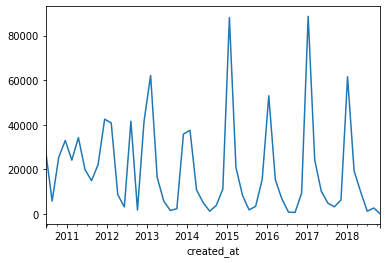

In [92]:
bills.assign(c=1).groupby(pd.Grouper(key='created_at', freq='60D'))['c'].sum().plot()

In [99]:
bill_subjects = bills['subjects'].dropna().str.split('|', expand=True)

In [102]:
bill_subjects.unstack().dropna().value_counts()

Other                                   73517
Budget, Spending, and Taxes             69924
Resolutions                             65529
Health                                  62555
State Agencies                          58727
Education                               58142
Legal Issues                            57114
Municipal and County Issues             48995
Crime                                   44672
Public Services                         44311
Transportation                          43886
Labor and Employment                    43685
Legislative Affairs                     38293
Commerce                                34604
Business and Consumers                  31831
Housing and Property                    31135
Environmental                           27289
Judiciary                               26237
Family and Children Issues              23932
Insurance                               18629
Campaign Finance and Election Issues    16558
Technology and Communication      

In [105]:
bills['state'].value_counts()

ny    124124
il    106362
tx     58244
nj     52211
ms     37312
mn     37243
hi     34401
md     32037
tn     30432
ca     29381
ma     28936
va     28332
pa     27697
la     20927
ga     20074
ok     18787
fl     18181
wv     17800
ct     17449
ri     16988
mi     16277
wa     15782
sc     15489
al     14517
mo     14173
az     13565
or     12462
dc     12284
nc     11972
ia     11469
in     10914
ky     10817
ar     10799
nm     10731
me     10456
wi      9525
vt      8013
nh      7637
ne      7271
ut      6762
oh      6343
co      5922
ks      5870
nv      5820
sd      5156
id      4962
mt      4752
de      3953
nd      3613
wy      3047
ak      2872
Name: state, dtype: int64

# Check vocabulary overlaps

In [2]:
ls data

 Volume in drive C is Local Disk
 Volume Serial Number is 3422-B048

 Directory of C:\Users\alexa\Projects\usc-research\newspaper-pages\notebooks\data

08/30/2019  12:47 PM    <DIR>          .
08/30/2019  12:47 PM    <DIR>          ..
08/30/2019  12:46 PM       823,452,289 fasttext_processed_data_test_unbalanced.txt
08/30/2019  12:47 PM       273,153,512 fasttext_processed_data_train_balanced.txt
08/26/2019  03:03 PM       887,330,707 processed_sampled_data_df.csv
08/29/2019  02:03 PM       243,785,982 processed_test_time_balanced_df.csv
08/28/2019  09:10 PM     1,962,242,125 processed_test_time_unbalanced_df.csv
08/28/2019  08:17 PM       646,630,837 processed_train_time_balanced_df.csv
08/28/2019  10:43 AM     2,005,622,976 semi_processed_test_time_unbalanced_df.csv
08/27/2019  03:08 PM     4,073,763,417 unprocessed_full_data_df.csv
08/23/2019  12:29 PM       510,590,632 unprocessed_sampled_data_df.csv
08/27/2019  04:21 PM       141,126,009 unprocessed_test_time_balanced_df.csv
08/27

In [2]:
newspaper_full_df = pd.read_csv('data/unprocessed_full_data_df.csv')
newspaper_text = newspaper_full_df[['headline', 'body']]
del newspaper_full_df

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (1,4,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
from sklearn.feature_extraction.text import CountVectorizer

In [4]:
newspaper_text = (
  newspaper_text
     .pipe(lambda df: df['headline'].fillna('') + ' ' + df['body'].fillna('').str.strip())
     .str.lower()
)

In [7]:
newspaper_text.to_csv('data/unprocessed_full_newspaper_body_headline.csv')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  """Entry point for launching an IPython kernel.


In [8]:
from collections import Counter

In [9]:
newspaper_counts = Counter()
for article in newspaper_text:
    newspaper_counts.update(article.split())

In [17]:
bill_counts = Counter()
for bill in bills['title'].dropna().str.lower():
    bill_counts.update(bill.split())

In [ ]:
bills['processed_title'] = bills['title'].swifter.apply(util.preprocess)

In [11]:
bills

,state,session,chamber,bill_id,title,created_at,updated_at,type,subjects
0,ak,27,lower,HB 1,"""An Act stating a public policy that allows a ...",2011-02-11 00:13:25.632,2012-08-30 00:53:28.369000,bill,"Health|Federal, State, and Local Relations|Ins..."
1,ak,27,lower,HB 10,"""An Act relating to the registration fee for n...",2011-02-11 00:13:25.680,2012-08-22 00:52:46.753000,bill,Transportation|Business and Consumers|Legal Is...
2,ak,27,lower,HB 100,"""An Act prohibiting growing or cultivating gen...",2011-02-11 00:13:25.975,2012-08-22 00:52:47.632000,bill,Recreation|Crime|Agriculture and Food|Technolo...
3,ak,27,lower,HB 101,"""An Act establishing the fourth Saturday of Ju...",2011-02-11 00:13:25.977,2012-08-30 00:53:33.573000,bill,Resolutions|Other|Public Services
4,ak,27,lower,HB 102,"""An Act suspending the motor fuel tax; and pro...",2011-02-11 00:13:25.979,2012-08-22 00:52:47.678000,bill,Business and Consumers|Recreation|Transportati...
5,ak,27,lower,HB 103,"""An Act relating to the procurement of supplie...",2011-02-11 00:13:25.982,2012-08-22 00:52:47.683000,bill,Energy|Civil Liberties and Civil Rights|Labor ...
6,ak,27,lower,HB 104,"""An Act renaming the Alaska performance schola...",2011-02-11 00:13:25.984,2012-10-05 00:52:30.947000,bill,"Commerce|Education|Executive Branch|Budget, Sp..."
7,ak,27,lower,HB 105,"""An Act relating to the Southeast State Forest...",2011-02-11 00:13:25.986,2012-08-30 00:53:33.821000,bill,Agriculture and Food|Environmental
8,ak,27,lower,HB 106,"""An Act extending the termination date of the ...",2011-02-11 00:13:25.989,2012-08-30 00:53:34.136000,bill,Environmental|Government Reform|Legal Issues|L...
9,ak,27,lower,HB 107,"""An Act making and amending appropriations, in...",2011-02-11 00:13:25.991,2012-08-22 00:52:47.764000,bill,"Commerce|Energy|Federal, State, and Local Rela..."


# JSONs

In [18]:
wget.download("https://data.openstates.org/legacy/json/ak.zip", out='../bills/bulk-bill-data/')

100% [..........................................................................] 5857672 / 5857672

'../bills/bulk-bill-data//ak.zip'

In [ ]:
import zipfile
with zipfile.ZipFile('path_to_zip_file', 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

In [30]:
import json

In [86]:
pd.Series(json.load(open(glob.glob('../bills/bulk-bill-data/jsons/ak/bills/ak/27/lower/*')[0]))['documents'])

0     {'url': 'http://www.legis.state.ak.us/basis/ge...
1     {'url': 'http://www.legis.state.ak.us/basis/ge...
2     {'url': 'http://www.legis.state.ak.us/basis/ge...
3     {'url': 'http://www.legis.state.ak.us/basis/ge...
4     {'url': 'http://www.legis.state.ak.us/basis/ge...
5     {'url': 'http://www.legis.state.ak.us/basis/ge...
6     {'url': 'http://www.legis.state.ak.us/basis/ge...
7     {'url': 'http://www.legis.state.ak.us/basis/ge...
8     {'url': 'http://www.legis.state.ak.us/basis/ge...
9     {'url': 'http://www.legis.state.ak.us/basis/ge...
10    {'url': 'http://www.legis.state.ak.us/basis/ge...
11    {'url': 'http://www.legis.state.ak.us/basis/ge...
12    {'url': 'http://www.legis.state.ak.us/basis/ge...
13    {'url': 'http://www.legis.state.ak.us/basis/ge...
14    {'url': 'http://www.legis.state.ak.us/basis/ge...
15    {'url': 'http://www.legis.state.ak.us/basis/ge...
16    {'url': 'http://www.legis.state.ak.us/basis/ge...
17    {'url': 'http://www.legis.state.ak.us/basi